In [1]:
# https://openai.com/index/introducing-structured-outputs-in-the-api/
# https://platform.openai.com/docs/guides/structured-outputs/introduction
# https://platform.openai.com/docs/guides/function-calling

# https://cookbook.openai.com/examples/structured_outputs_intro
# https://cookbook.openai.com/examples/structured_outputs_multi_agent

# Guía Didáctica: Sistema Multi-Agente con Structured Outputs
En esta guía, exploraremos cómo construir un sistema multi-agente utilizando la característica de Structured Outputs de OpenAI. Implementaremos un sistema que procesa datos, realiza análisis estadísticos y crea visualizaciones.


### Why build a Multi-Agent System?
When using function calling, if the number of functions (or tools) increases, the performance may suffer.

To mitigate this, we can logically group the tools together and have specialized "agents" that are able to solve specific tasks or sub-tasks, which will increase the overall system performance.

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

### 1. Configuración del Entorno
Primero, importamos las bibliotecas necesarias y configuramos el cliente de OpenAI.

In [12]:
from openai import OpenAI
from IPython.display import Image
import json
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import numpy as np

In [13]:
client = OpenAI()
MODEL = "gpt-4o-2024-08-06"

### 2. Definición de Modelos Pydantic
Structured Outputs utiliza schemas JSON para garantizar que las respuestas del modelo se ajusten a una estructura específica. En Python, usamos Pydantic para definir estos schemas de una manera más pythonica.

In [15]:
class SendQueryToAgents(BaseModel):
    agents: List[str] = Field(..., description="An array of agent names to send the query to.")
    query: str = Field(..., description="The user query to send.")

class CleanedData(BaseModel):
    data: str = Field(..., description="The cleaned dataset in CSV format.")

class StatisticalAnalysis(BaseModel):
    summary: str = Field(..., description="A summary of the statistical analysis.")
    mean: float = Field(..., description="The mean value of the data.")
    median: float = Field(..., description="The median value of the data.")
    std_dev: float = Field(..., description="The standard deviation of the data.")

class DataPoint(BaseModel):
    x: float
    y: float

class LineChartData(BaseModel):
    x_label: str = Field(..., description="Label for the x-axis.")
    y_label: str = Field(..., description="Label for the y-axis.")
    data_points: List[DataPoint] = Field(..., description="List of data points for the line chart.")

Cada clase define la estructura que esperamos recibir del modelo de lenguaje. El uso de Field nos permite añadir descripciones, que se convierten en parte del schema JSON.


### 3. Definición de Prompts del Sistema
Definimos prompts para cada agente en nuestro sistema:


#### Agents set up
The use case we will tackle is a data analysis task.

Let's first set up our 4-agents system:

- Triaging agent: Decides which agent(s) to call
- Data pre-processing Agent: Prepares data for analysis - for example by cleaning it up
- Data Analysis Agent: Performs analysis on the data
- Data Visualization Agent: Visualizes the output of the analysis to extract insights

We will start by defining the system prompts for each of these agents.

In [16]:
triaging_system_prompt = """You are a Triaging Agent. Your role is to assess the user's query and route it to the relevant agents. The agents available are:
- Data Processing Agent: Cleans, transforms, and aggregates data.
- Analysis Agent: Performs statistical, correlation, and regression analysis.
- Visualization Agent: Creates bar charts, line charts, and pie charts.

Use the send_query_to_agents tool to forward the user's query to the relevant agents. Also, use the speak_to_user tool to get more information from the user if needed."""

processing_system_prompt = """You are a Data Processing Agent. Your role is to clean, transform, and aggregate data using the following tools:
- clean_data
- transform_data
- aggregate_data"""

analysis_system_prompt = """You are an Analysis Agent. Your role is to perform statistical, correlation, and regression analysis using the following tools:
- stat_analysis
- correlation_analysis
- regression_analysis"""

visualization_system_prompt = """You are a Visualization Agent. Your role is to create bar charts, line charts, and pie charts using the following tools:
- create_bar_chart
- create_line_chart
- create_pie_chart"""

Estos prompts guían el comportamiento de cada agente en el sistema.


### 4. Funciones de Ejecución de Herramientas


We will then define the tools for each agent.

Apart from the triaging agent, each agent will be equipped with tools specific to their role:

In [17]:
def clean_data(data: str) -> pd.DataFrame:
    data_io = StringIO(data)
    df = pd.read_csv(data_io)
    df_cleaned = df.drop_duplicates().dropna()
    return df_cleaned

def perform_statistical_analysis(data: str) -> dict:
    df = pd.read_csv(StringIO(data))
    return {
        "mean": df.mean().to_dict(),
        "median": df.median().to_dict(),
        "std_dev": df.std().to_dict()
    }

def create_line_chart(data: LineChartData):
    x = [point.x for point in data.data_points]
    y = [point.y for point in data.data_points]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'o-')
    plt.xlabel(data.x_label)
    plt.ylabel(data.y_label)
    plt.title(f'{data.y_label} vs {data.x_label}')
    plt.grid(True)
    plt.show()

Estas funciones implementan la lógica real detrás de las tareas que nuestros agentes solicitan.


### 5. Funciones de Manejo de Agentes
Ahora, definimos funciones para manejar cada agente:


In [18]:
def handle_data_processing_agent(query: str) -> CleanedData:
    completion = client.beta.chat.completions.parse(
        model=MODEL,
        temperature=0,
        messages=[
            {"role": "system", "content": processing_system_prompt},
            {"role": "user", "content": query}
        ],
        response_format=CleanedData,
    )
    return completion.choices[0].message.parsed

def handle_analysis_agent(query: str) -> StatisticalAnalysis:
    completion = client.beta.chat.completions.parse(
        model=MODEL,
        temperature=0,
        messages=[
            {"role": "system", "content": analysis_system_prompt},
            {"role": "user", "content": query}
        ],
        response_format=StatisticalAnalysis,
    )
    return completion.choices[0].message.parsed

def handle_visualization_agent(query: str) -> LineChartData:
    completion = client.beta.chat.completions.parse(
        model=MODEL,
        temperature=0,
        messages=[
            {"role": "system", "content": visualization_system_prompt},
            {"role": "user", "content": query}
        ],
        response_format=LineChartData,
    )
    return completion.choices[0].message.parsed

Estas funciones utilizan client.beta.chat.completions.parse(), que es parte de la funcionalidad de Structured Outputs. El parámetro response_format especifica el modelo Pydantic que queremos que la API utilice para estructurar su respuesta.


### 6. Función Principal de Manejo de Mensajes
Finalmente, definimos la función principal que maneja los mensajes del usuario:


In [19]:
def handle_user_message(user_query: str):
    completion = client.beta.chat.completions.parse(
        model=MODEL,
        temperature=0,
        messages=[
            {"role": "system", "content": triaging_system_prompt},
            {"role": "user", "content": user_query}
        ],
        response_format=SendQueryToAgents,
    )

    triage_result = completion.choices[0].message.parsed
    
    results = {}
    for agent in triage_result.agents:
        if agent == "Data Processing Agent":
            results['cleaned_data'] = handle_data_processing_agent(triage_result.query)
        elif agent == "Analysis Agent":
            results['analysis'] = handle_analysis_agent(triage_result.query)
        elif agent == "Visualization Agent":
            results['visualization'] = handle_visualization_agent(triage_result.query)

    return results

Esta función primero usa el agente de triaje para decidir qué agentes deben manejar la consulta del usuario, y luego llama a los agentes apropiados.


### 7. Uso del Sistema
Aquí hay un ejemplo de cómo usar el sistema:

Cleaned Data:
   house_size  house_price
0          90          100
1          80           90
2         100          120
3          95          110

Statistical Analysis:
Summary: The dataset contains house sizes and their corresponding prices. After removing duplicates, the dataset has 4 unique entries. The mean house size is 91.25 m3, and the mean house price is $105. The median house size is 92.5 m3, and the median house price is $105. The standard deviation for house sizes is 7.5 m3, and for house prices, it is $15.
Mean: 91.25
Median: 92.5
Standard Deviation: 7.5

Creating Line Chart...


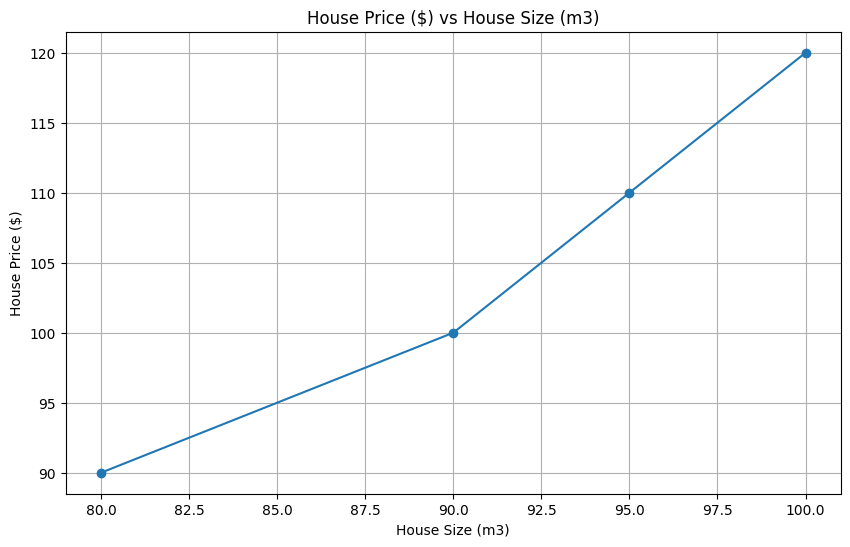

In [20]:
user_query = """
Below is some data. I want you to first remove the duplicates then analyze the statistics of the data as well as plot a line chart.

house_size (m3), house_price ($)
90, 100
80, 90
100, 120
90, 100
95, 110
"""

results = handle_user_message(user_query)

# Procesar y mostrar resultados
if 'cleaned_data' in results:
    cleaned_df = clean_data(results['cleaned_data'].data)
    print("Cleaned Data:")
    print(cleaned_df)

if 'analysis' in results:
    print("\nStatistical Analysis:")
    print(f"Summary: {results['analysis'].summary}")
    print(f"Mean: {results['analysis'].mean}")
    print(f"Median: {results['analysis'].median}")
    print(f"Standard Deviation: {results['analysis'].std_dev}")

if 'visualization' in results:
    print("\nCreating Line Chart...")
    create_line_chart(results['visualization'])

Este ejemplo muestra cómo el sistema procesa una consulta del usuario, limpia los datos, realiza un análisis estadístico y crea una visualización.

#### Conclusión
Este sistema multi-agente demuestra el poder de Structured Outputs. Al definir schemas precisos con Pydantic, podemos garantizar que las respuestas del modelo se ajusten exactamente a la estructura que necesitamos, lo que facilita el procesamiento posterior y reduce la necesidad de manejar casos extremos o validar las respuestas del modelo.
La característica de Structured Outputs nos permite crear sistemas más robustos y confiables que pueden manejar tareas complejas de manera modular y estructurada.